<a href="https://colab.research.google.com/github/AlessandroMele/deep_eyes_recognition/blob/main/transfer_learning_opend_closed_eyes_rgb_gray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
"""
import glob
import os
from shutil import copyfile


list_of_dirs = glob.glob('/content/mrlEyes_2018_01/s0*')

for item in list_of_dirs:
  #print(item + "/*_1_*.png")
  opened_eye = (glob.glob(item + "/*"))
  for sub_item in opened_eye:
    s = sub_item.split("/")        
    file_name = s[-1]
    file_status = file_name.split("_")    
    if(int(file_status[4]) == 1):   
      copyfile(sub_item, "/content/dataset/open/" + file_name)  
    else:
      copyfile(sub_item, "/content/dataset/close/" + file_name)  
  #closed_eye = (glob.glob(item + "/*_*_*_*_0_*.png"))
  #for sub_item in closed_eye:
  #  print(sub_item.split("/")[-1])
  #copyfile(sub_item, "/content/dataset/close/" + sub_item.split("/")[-1])
"""

'\nimport glob\nimport os\nfrom shutil import copyfile\n\n\nlist_of_dirs = glob.glob(\'/content/mrlEyes_2018_01/s0*\')\n\nfor item in list_of_dirs:\n  #print(item + "/*_1_*.png")\n  opened_eye = (glob.glob(item + "/*"))\n  for sub_item in opened_eye:\n    s = sub_item.split("/")        \n    file_name = s[-1]\n    file_status = file_name.split("_")    \n    if(int(file_status[4]) == 1):   \n      copyfile(sub_item, "/content/dataset/open/" + file_name)  \n    else:\n      copyfile(sub_item, "/content/dataset/close/" + file_name)  \n  #closed_eye = (glob.glob(item + "/*_*_*_*_0_*.png"))\n  #for sub_item in closed_eye:\n  #  print(sub_item.split("/")[-1])\n  #copyfile(sub_item, "/content/dataset/close/" + sub_item.split("/")[-1])\n'

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (96, 96)

#!rm -rf /content/dataset/.ipynb_checkpoints
#train_dir ="/content/dataset/"

train_dir = "/content/drive/MyDrive/PROGETTO_CV_DL/immagini davide/"

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset="training",
                                             seed = 123
                                             )

validation_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset="validation",
                                             seed = 123
                                             )

Found 111 files belonging to 6 classes.
Using 89 files for training.
Found 111 files belonging to 6 classes.
Using 22 files for validation.


Show the first nine images and labels from the training set:

['alto', 'basso', 'centro_orizzontale', 'centro_verticale', 'destra', 'sinistra']


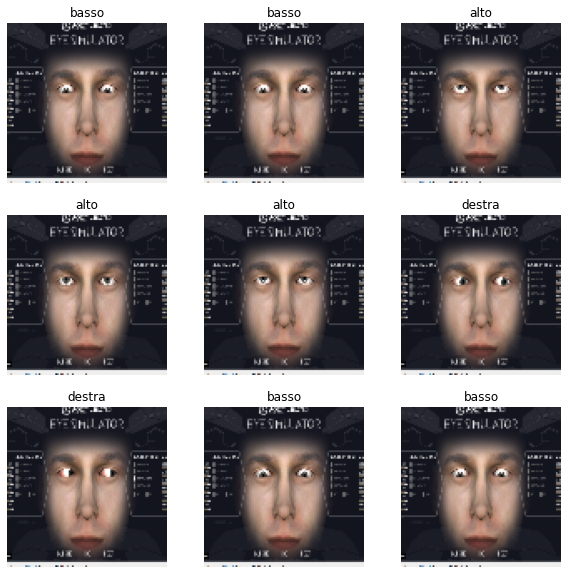

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
l = train_dataset.take(1)

print(class_names)

for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
class_names = train_dataset.class_names
print(class_names)

['alto', 'basso', 'centro_orizzontale', 'centro_verticale', 'destra', 'sinistra']


As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)

#!mkdir /content/test
#test_dir = "/content/test/"
#!rm -rf /content/test/.ipynb_checkpoints

#test_dataset = image_dataset_from_directory(test_dir,
#                                             shuffle=True,
#                                             batch_size=BATCH_SIZE,
#                                             image_size=IMG_SIZE,
#                                            )
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 1
Number of test batches: 0


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),

])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

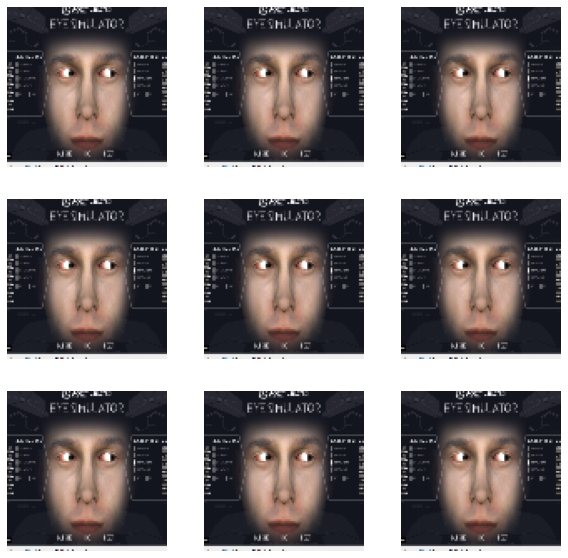

In [41]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [13]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [20]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                             

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [23]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see good accuracy on the validation set.


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

1/1 [==============================] - 5s 5s/step - loss: -7.8897 - accuracy: 0.2273


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: -7.89
initial accuracy: 0.23


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
3/3 [==============================] - 6s 457ms/step - loss: -3.9517 - accuracy: 0.2809 - val_loss: -8.2362 - val_accuracy: 0.2273
Epoch 2/10
3/3 [==============================] - 3s 445ms/step - loss: -4.0721 - accuracy: 0.2809 - val_loss: -8.5702 - val_accuracy: 0.2273
Epoch 3/10
3/3 [==============================] - 3s 451ms/step - loss: -4.4114 - accuracy: 0.2809 - val_loss: -8.9084 - val_accuracy: 0.2273
Epoch 4/10
3/3 [==============================] - 3s 445ms/step - loss: -4.4830 - accuracy: 0.2809 - val_loss: -9.2438 - val_accuracy: 0.2273
Epoch 5/10
3/3 [==============================] - 3s 440ms/step - loss: -4.4533 - accuracy: 0.2809 - val_loss: -9.5747 - val_accuracy: 0.2273
Epoch 6/10
3/3 [==============================] - 3s 448ms/step - loss: -4.8924 - accuracy: 0.2809 - val_loss: -9.9096 - val_accuracy: 0.2273
Epoch 7/10
3/3 [==============================] - 3s 454ms/step - loss: -5.0550 - accuracy: 0.2809 - val_loss: -10.2457 - val_accuracy: 0.2273
Epoch

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

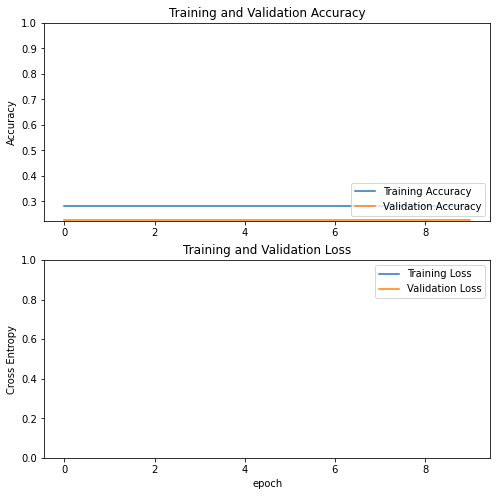

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                             

In [33]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
3/3 [==============================] - 13s 1s/step - loss: -9.4734 - accuracy: 0.2809 - val_loss: -27.5486 - val_accuracy: 0.2273
Epoch 11/20
3/3 [==============================] - 3s 630ms/step - loss: -19.5470 - accuracy: 0.2809 - val_loss: -41.5916 - val_accuracy: 0.2273
Epoch 12/20
3/3 [==============================] - 3s 635ms/step - loss: -27.5493 - accuracy: 0.2809 - val_loss: -52.9504 - val_accuracy: 0.2273
Epoch 13/20
3/3 [==============================] - 3s 623ms/step - loss: -34.6815 - accuracy: 0.2809 - val_loss: -65.4724 - val_accuracy: 0.2273
Epoch 14/20
3/3 [==============================] - 3s 643ms/step - loss: -42.3428 - accuracy: 0.2809 - val_loss: -77.2857 - val_accuracy: 0.2273
Epoch 15/20
3/3 [==============================] - 3s 639ms/step - loss: -49.9391 - accuracy: 0.2809 - val_loss: -87.9196 - val_accuracy: 0.2273
Epoch 16/20
3/3 [==============================] - 3s 634ms/step - loss: -57.3895 - accuracy: 0.2809 - val_loss: -101.6019 - val_accu

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. If the validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

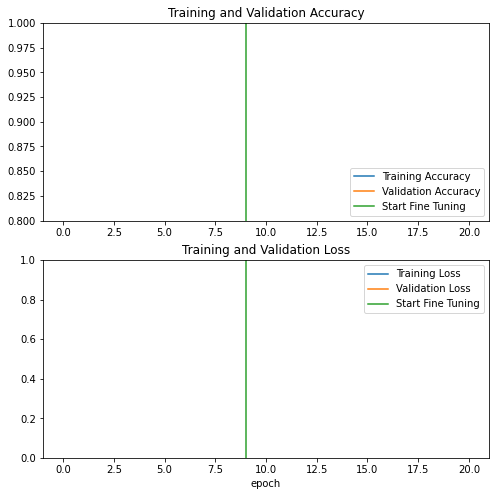

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:923: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: ignored

And now you are all set to use this model to predict if your eye is opened or closed.

In [39]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
print(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

StopIteration: ignored

Evaluate final results using confusion matrix

In [ ]:
confusion_m = tf.math.confusion_matrix(labels = label_batch , predictions = predictions)
print(confusion_m)
accuracy = np.trace(confusion_m) / float(np.sum(confusion_m))
misclass = 1 - accuracy
print("OA: ",accuracy)

# Saving and zipping model to test other images without re-training the model

In [ ]:
model.save('my_eye_model')

In [ ]:
!zip -r my_eye_model.zip /content/my_eye_model/

In [ ]:
!unzip my_eye_model.zip

# Run model on unknow images...

In [40]:
from tensorflow import keras
model = keras.models.load_model('/content/content/my_eye_model')

OSError: ignored

In [ ]:
model.summary()

In [ ]:
!unzip test.zip

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import glob
list_of_dirs = glob.glob('/content/test/*')

for item in list_of_dirs:
  #print(item)
  img = cv2.imread(item,cv2.IMREAD_GRAYSCALE) #you can skif if you have in memory a grayscale image...
  resized = cv2.resize(img, (96,96), interpolation=cv2.INTER_CUBIC)

  img_r = np.zeros((1,resized.shape[0], resized.shape[1], 3))  
  for i in range(3):  
    img_r[0,:,:,i] = resized
    
  predictions = model.predict(img_r)
  #print(predictions)

  # Apply a sigmoid since our model returns logits
  predictions = tf.nn.sigmoid(predictions)
  #print(predictions)
  predictions = tf.where(predictions < 0.5, 0, 1)
  cv2_imshow(resized)
  print('Predictions:\n', predictions.numpy())
  #print('Labels:\n', label_batch)

In [ ]:
a = 2

In [ ]:
print(a ** 3)